## Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-25 21:40:20.730352+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-25 21:40:26.253959+10:00 - Saved token with '2025-06-26 01:40:26+10:00' expiry...


## Parameter Tuning

In [334]:
TRX_THRESHOLD = 16 # Min N frequent pairs
QUANTILE = 0.99 # Nth percentile of metric similarity
TOP_N = 5 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [335]:
filtered_df = df[(df['PRIMARY_ID'] != '400 RODENT PEST CONTROL' ) & ( df['SECONDARY_ID']!='400 RODENT PEST CONTROL')]

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


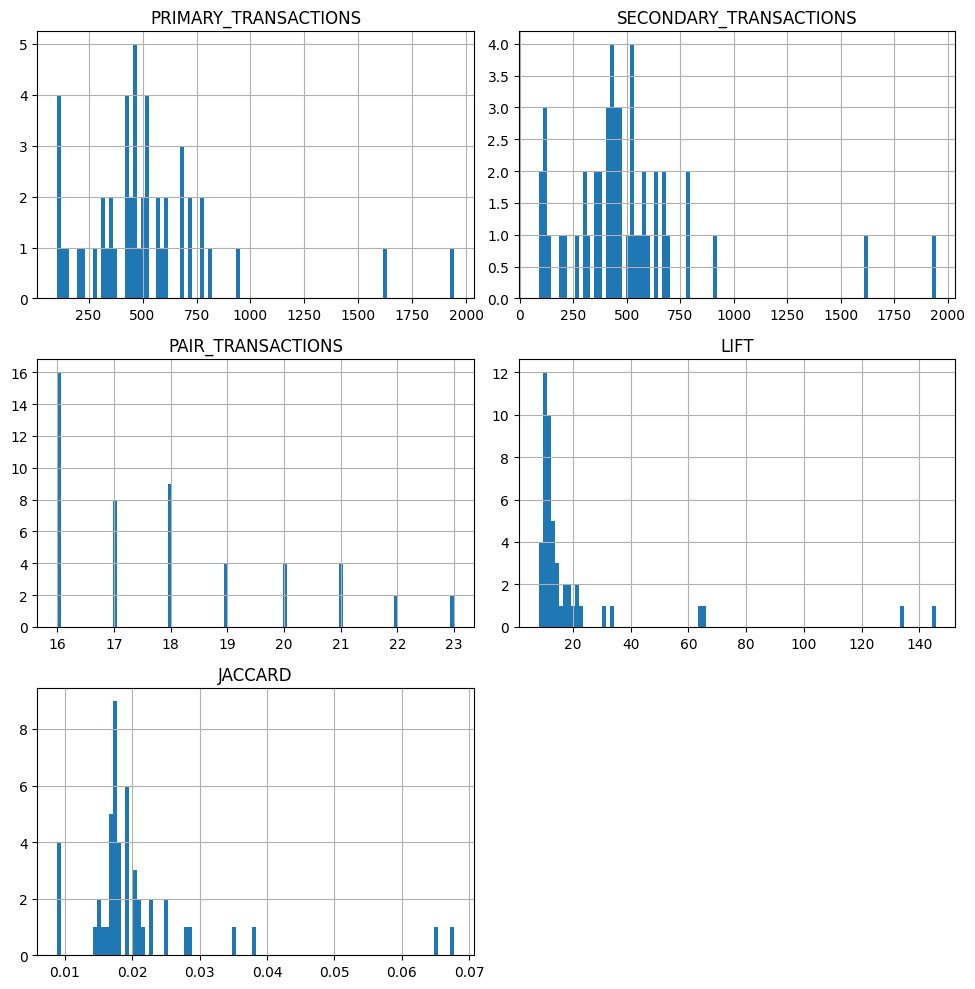

In [336]:
# Plot histograms of numerical columns
numeric_cols = filtered_df.select_dtypes(include='number').columns
filtered_df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

In [337]:
filtered_df.sort_values(by='PAIR_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
21014,400 LANDSCAPING TIMBER,400 FENCING TIMBER,320,526,2024-06-01,2025-05-01,23,20.969190,0.027947
11587,400 FENCING TIMBER,400 LANDSCAPING TIMBER,526,309,2024-06-01,2025-05-01,23,21.715666,0.028325
9631,400 DRY MIX,400 FENCING TIMBER,782,526,2024-06-01,2025-05-01,22,8.207667,0.017107
11548,400 FENCING TIMBER,400 DRY MIX,526,782,2024-06-01,2025-05-01,22,8.207667,0.017107
19471,400 INTERIOR BROADWALL PAINT,400 INTERIOR PAINT,714,458,2024-06-01,2025-05-01,21,9.854739,0.018245
41442,401 BATHROOM ACCESSORIES,401 BATHROOM DECOR,680,436,2024-06-01,2025-05-01,21,10.869597,0.019178
41698,401 BATHROOM DECOR,401 BATHROOM ACCESSORIES,449,680,2024-06-01,2025-05-01,21,10.554887,0.018953
19715,400 INTERIOR PAINT,400 INTERIOR BROADWALL PAINT,458,645,2024-06-01,2025-05-01,21,10.825652,0.019409
37245,400 UNDERCOAT,400 INTERIOR PAINT,362,458,2024-06-01,2025-05-01,20,18.511665,0.025000
54797,401 POOL N SPA WATER TREATMENT,401 POOL AND SPA MAINTENANCE,937,262,2024-06-01,2025-05-01,20,12.501976,0.016964


In [338]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [339]:
fig.show()

In [340]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(labelled_df)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,PAIR_TRANSACTIONS,LIFT,segment
0,401 BATHROOM DECOR,401 BATHROOM ACCESSORIES,449,680,21,10.554887,0
1,401 BATHROOM ACCESSORIES,401 BATHROOM DECOR,680,436,21,10.869597,0
2,401 TOOLS AND ACCESSORIES,401 FLOORING ADHESIVE,137,141,17,134.102604,1
3,401 FLOORING ADHESIVE,401 TOOLS AND ACCESSORIES,148,120,17,145.661092,1
4,403 DRAPERY FITTINGS,403 CURTAINS,432,100,18,63.940833,2
5,403 CURTAINS,403 DRAPERY FITTINGS,110,383,18,65.036696,2
6,400 KNIVES AND SHARPENING,400 STRIKNG AND WRECKNG TOOLS,805,408,18,8.410194,3
7,400 DRIVING TOOLS,400 SPANNERS AND SOCKETS,573,470,18,10.256745,3
8,400 CLMPNG AND GRIPPING TOOLS,400 SPANNERS AND SOCKETS,520,470,17,10.674247,3
9,400 SPANNERS AND SOCKETS,400 CLMPNG AND GRIPPING TOOLS,470,520,17,10.674247,3


## Regroup segment

In [344]:
macro_mapping = {
    0:  'Finishing & Fit-Out',      
    1:  'Tools & Consumables',      
    2:  'Finishing & Fit-Out',       
    3:  'Tools & Consumables',       
    4:  'Structural & Site Prep',   
    5:  'Tools & Consumables',      
    6:  'Tools & Consumables',       
    7:  'Outdoor Systems & Garden',   
    8:  'Outdoor Systems & Garden',  
    9:  'Outdoor Systems & Garden',  
    10: 'Finishing & Fit-Out',      
    11: 'Tools & Consumables',      
    12: 'Tools & Consumables',    
    13: 'Structural & Site Prep',     
    14: 'Other',                  
    15: 'Tools & Consumables',        
}

# Relabel and aggregate
labelled_df['Macro-segment'] = labelled_df['segment'].map(macro_mapping)

In [345]:
labelled_df.groupby(['Macro-segment'], as_index=False).agg(total_PRIMARY_TRANSACTIONS=('PRIMARY_TRANSACTIONS', 'sum')).sort_values('total_PRIMARY_TRANSACTIONS')

,Macro-segment,total_PRIMARY_TRANSACTIONS
1,Other,2048
3,Structural & Site Prep,4237
2,Outdoor Systems & Garden,4648
0,Finishing & Fit-Out,4739
4,Tools & Consumables,9646


In [346]:
labelled_df.groupby(['Macro-segment', 'PRIMARY_ID'], as_index=False).agg(total_PRIMARY_TRANSACTIONS=('PRIMARY_TRANSACTIONS', 'sum')).sort_values(['Macro-segment', 'total_PRIMARY_TRANSACTIONS'])

,Macro-segment,PRIMARY_ID,total_PRIMARY_TRANSACTIONS
5,Finishing & Fit-Out,403 CURTAINS,110
6,Finishing & Fit-Out,403 DRAPERY FITTINGS,432
4,Finishing & Fit-Out,401 BATHROOM DECOR,449
3,Finishing & Fit-Out,401 BATHROOM ACCESSORIES,680
2,Finishing & Fit-Out,400 UNDERCOAT,724
1,Finishing & Fit-Out,400 INTERIOR PAINT,916
0,Finishing & Fit-Out,400 INTERIOR BROADWALL PAINT,1428
7,Other,401 AUTO ELECTRICAL,105
8,Other,401 CABLE AND CONDUIT,1943
13,Outdoor Systems & Garden,400 WATERING SYSTEMS,242


**Finishing & Fit-Out**

While sealing cracks, painting or refitting interiors (bathroom décor, curtains, undercoat/paint), customers only bother sealing cracks or repainting when they’ve actually found chew marks, droppings or holes in skirting boards.

**Tools & Consumables**

Customers refreshing their hand-tool kits (spanners, cutting & grinding tools, cordless batteries, door hardware) naturally add rodent bait and traps to their maintenance trolley in case they discovers a rodent problem in that same project.

**Structural & Site Prep**

Masons, landscapers and plumbers working on dry-mix mortar, fencing timber or PVC guttering/drainage are already opening walls and grounds—ideal moments to install control products and repair damage left by rodents.

**Outdoor Systems & Garden**

Irrigation clogs, hose leaks or loose pool covers often hide rodent activity under mulch or inside equipment housings. Gardeners and pool-service crews repairing irrigation lines, hoses, pumps or small-engine equipment spot burrows and place baits as part of routine outdoor servicing. 

**Other** - EXCLUDE
Auto-electrical co-buys (cables, conduits) are unrelated maintenance noise and can be dropped from a focused rodent-control analysis.

**NOT USED**


Customers buying rodent pest control also commonly buy…
- Food & garden attractants → Prevention
- Renovation tools & materials → Discovery during works
- Outdoor timber or irrigation gear → Nesting hotspots
- Buckets, pipes, insulation → Utility zones needing sealing or inspection